# Cosponsorship analysis 

This notebook aims to
1. get sponsorship and cosponsorship information from bills voted by the 115th senate

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import requests
import seaborn as sns

In [2]:
ALL_LAWS_PATH = '../data/all-votes/laws_20years.csv'
VOTES_115 = '../data/all-votes/votes_115.csv'
API_KEY = 'EaNt0652GV92i9U9Mlhs0ggCwLPyRB23bc6qAeyX'


In [3]:
all_laws = pd.read_csv(ALL_LAWS_PATH)
bills_115 = all_laws[(all_laws['congress'] == 115) & (all_laws['bill_api_uri'].notnull())]

In [4]:
bills_115_ = bills_115['bill_api_uri'].unique()

In [5]:
bills_115_names = [i.split('/')[7].split('.')[0] for i in bills_115['bill_api_uri'].unique()]

In [7]:
bills_sponsorship = []

for i in range(0, len(bills_115_)):
    url = bills_115_[i][:-5] + '/cosponsors.json'
    
    d = {}
    try:
        req = requests.get(url, headers={'X-API-Key': API_KEY}).json()
        results = req['results'][0]
        d['bill_url'] = bills_115_[i]
        d['sponsor_party'] = results['sponsor_party']
        d['sponsor_id'] = results['sponsor_id']
        d['sponsor_title'] = results['sponsor_title']
        d['committees'] = results['committees']
        d['number_of_cosponsors'] = results['number_of_cosponsors']
        d['cosponsors_by_party'] = results['cosponsors_by_party']
        d['cosponsors'] = results['cosponsors']

        bills_sponsorship.append(d)
    except:
        pass
    

In [8]:
bills_sponsorship = pd.DataFrame(bills_sponsorship)

In [9]:
bills_115 = bills_115.merge(bills_sponsorship, left_on = 'bill_api_uri', right_on = 'bill_url')

In [10]:
LOOKUP_RESULT = {
'Agreed to': 'passed', 'Rejected': 'rejected', 'Nomination Confirmed': 'passed',
'Cloture Motion Agreed to': 'passed', 'Amendment Rejected': 'rejected', 'Confirmed': 'passed',
'Passed': 'passed', 'Amendment Agreed to': 'passed', 'Motion Rejected': 'rejected',
'Motion Agreed to': 'passed', 'Bill Passed': 'passed', 'Motion to Table Agreed to': 'passed',
'Cloture Motion Rejected': 'rejected', 'Motion to Proceed Agreed to': 'passed',
'Cloture on the Motion to Proceed Agreed to': 'passed', 'Cloture on the Motion to Proceed Rejected': 'rejected'
}
bills_115['result_ok'] = bills_115.result.apply(lambda x: LOOKUP_RESULT.get(x, 'undefined'))

### Get status of votes according to sponsor party:

In [11]:
bills_115 = bills_115[bills_115['result_ok'].isin(['passed', 'rejected'])]

In [12]:
N_BILLS = len(bills_115.bill_api_uri.unique())

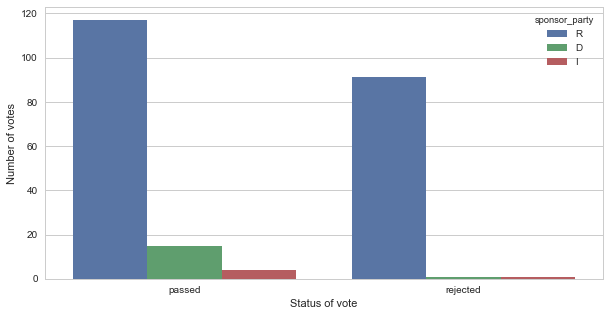

In [13]:
plt.figure(figsize=(10,5))
sns.set(style="whitegrid")
sns.countplot(x="result_ok", hue = "sponsor_party", data= bills_115)
plt.ylabel('Number of votes');
plt.xlabel('Status of vote');

### Get status of votes according to number of cosponsor for each party:

In [14]:
# Number of cosponsors of each party:
bills_115['nb_cosponsors_R']=0
bills_115['nb_cosponsors_D']=0
bills_115['nb_cosponsors_I']=0

for i in range(len(bills_115)):
    if bills_115.number_of_cosponsors.iloc[i]:
        for item in bills_115.cosponsors_by_party.iloc[i]:
            bills_115['nb_cosponsors_'+item['party']['id']].iloc[i]= int(item['party']['sponsors'])

In [15]:
bills_115=bills_115.drop(['result','total_no', 'total_not_voting', 'total_yes', 'cosponsors_by_party','number_of_cosponsors','congress'], axis=1)

In [16]:
bills_115.columns

Index(['bill_api_uri', 'date', 'democrats_no', 'democrats_yes',
       'independent_no', 'independent_yes', 'month', 'republican_no',
       'republican_yes', 'vote_type', 'vote_uri', 'year', 'bill_url',
       'committees', 'cosponsors', 'sponsor_id', 'sponsor_party',
       'sponsor_title', 'result_ok', 'nb_cosponsors_R', 'nb_cosponsors_D',
       'nb_cosponsors_I'],
      dtype='object')

In [17]:
bills_115['cosponsors_sen'] = ''
bills_115['cosponsors_rep'] = ''
bills_115['cosponsors_del'] = ''

In [18]:
for i in range(len(bills_115)):
    cosponsors_list_sen = []
    cosponsors_list_rep = []
    cosponsors_list_del = []
    for j in range(len(bills_115.cosponsors.iloc[i])):
        if bills_115.cosponsors.iloc[i][j]['cosponsor_title'] == 'Sen.':
            cosponsors_list_sen.append(bills_115.cosponsors.iloc[i][j]['cosponsor_id'])
        elif bills_115.cosponsors.iloc[i][j]['cosponsor_title'] == 'Rep.':
            cosponsors_list_rep.append(bills_115.cosponsors.iloc[i][j]['cosponsor_id'])
        elif bills_115.cosponsors.iloc[i][j]['cosponsor_title'] == 'Del.':
            cosponsors_list_del.append(bills_115.cosponsors.iloc[i][j]['cosponsor_id'])
    bills_115.cosponsors_sen.iloc[i] = cosponsors_list_sen
    bills_115.cosponsors_rep.iloc[i] = cosponsors_list_rep
    bills_115.cosponsors_del.iloc[i] = cosponsors_list_del

In [19]:
bills_115 = bills_115.drop('cosponsors', axis = 1)

In [20]:
aux_data = pd.melt(bills_115.loc[:,['result_ok', 'nb_cosponsors_R', 'nb_cosponsors_D', 'nb_cosponsors_I']], id_vars="result_ok", var_name="party", value_name="cosponsors_nb")
aux_data.party = aux_data.party.map({'nb_cosponsors_R': 'R', 'nb_cosponsors_D':'D', 'nb_cosponsors_I':'I'})

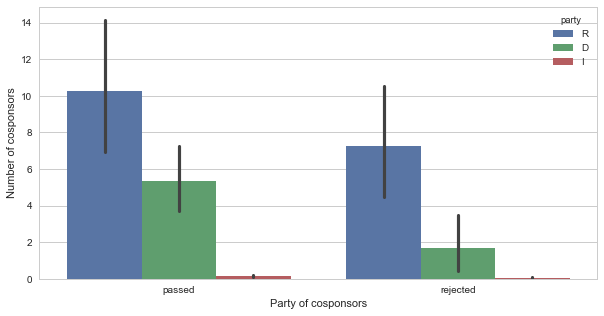

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(x='result_ok', y='cosponsors_nb', hue='party', data=aux_data)
plt.ylabel('Number of cosponsors');
plt.xlabel('Party of cosponsors');

In [22]:
votes_115 = pd.read_csv(VOTES_115)
members_115 = votes_115.member_id.unique()

### Evaluate proportion of senators sponsoring bills:

In [23]:
print('{0:0.2f}% of the bill sponsors are part of the senate.'.format(100*sum([bills_115[bills_115.sponsor_id == i].sponsor_title.iloc[0]=='Sen.' for i in bills_115.sponsor_id.unique()])/len(bills_115.sponsor_id.unique())))

41.46% of the bill sponsors are part of the senate.


In [24]:
cosponsors_sen_ids=[]
cosponsors_rep_ids=[]

for i, j in enumerate(bills_115.cosponsors_sen):
    cosponsors_sen_ids = cosponsors_sen_ids + bills_115.cosponsors_sen.iloc[i]
    cosponsors_rep_ids = cosponsors_rep_ids + bills_115.cosponsors_rep.iloc[i]

cosponsors_rep_ids=list(set(cosponsors_rep_ids))
cosponsors_sen_ids=list(set(cosponsors_sen_ids))
cosponsors_ids = cosponsors_sen_ids + cosponsors_rep_ids

In [25]:
print('{0:0.2f}% of the bill cosponsors are part of the senate'.format(100*len(cosponsors_sen_ids)/len(cosponsors_ids)))

23.89% of the bill cosponsors are part of the senate


### Influence of sponsor title:

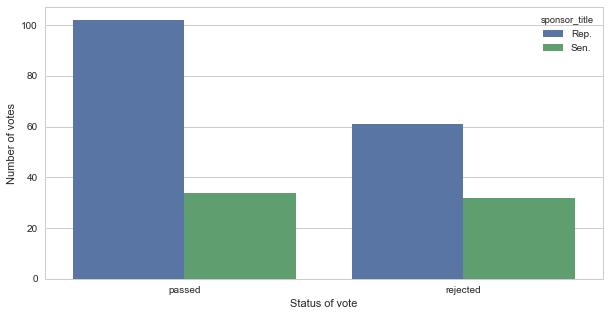

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(x='result_ok', hue='sponsor_title', data=bills_115)
plt.ylabel('Number of votes');
plt.xlabel('Status of vote');

### Influence of cosponsors title:

In [27]:
aux_sen=[]
aux_rep=[]

for i, j in enumerate(bills_115.cosponsors_sen):
    aux_sen.append(len(bills_115.cosponsors_sen.iloc[i]))
    aux_rep.append(len(bills_115.cosponsors_rep.iloc[i]))

In [28]:
aux_data_ = pd.DataFrame(bills_115['result_ok']).join(pd.DataFrame(data=np.array([aux_rep,aux_sen]).T, index=bills_115.index, columns=['n_rep', 'n_sen']))
aux_data_ = pd.melt(aux_data_, id_vars="result_ok", var_name="title", value_name="cosponsors_nb")

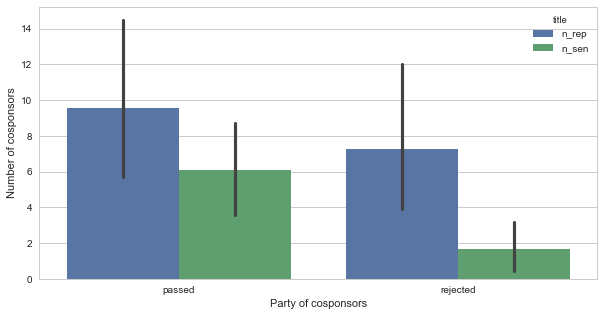

In [29]:
plt.figure(figsize=(10,5))
sns.barplot(x='result_ok', y='cosponsors_nb', hue='title', data=aux_data_)
plt.ylabel('Number of cosponsors');
plt.xlabel('Party of cosponsors');

### Cosponsors profile 

In [30]:
aux_data1=bills_115.loc[:,['result_ok', 'nb_cosponsors_R', 'nb_cosponsors_D', 'nb_cosponsors_I']].join(pd.DataFrame(data=np.array([aux_rep,aux_sen]).T, index=bills_115.index, columns=['n_rep', 'n_sen']))

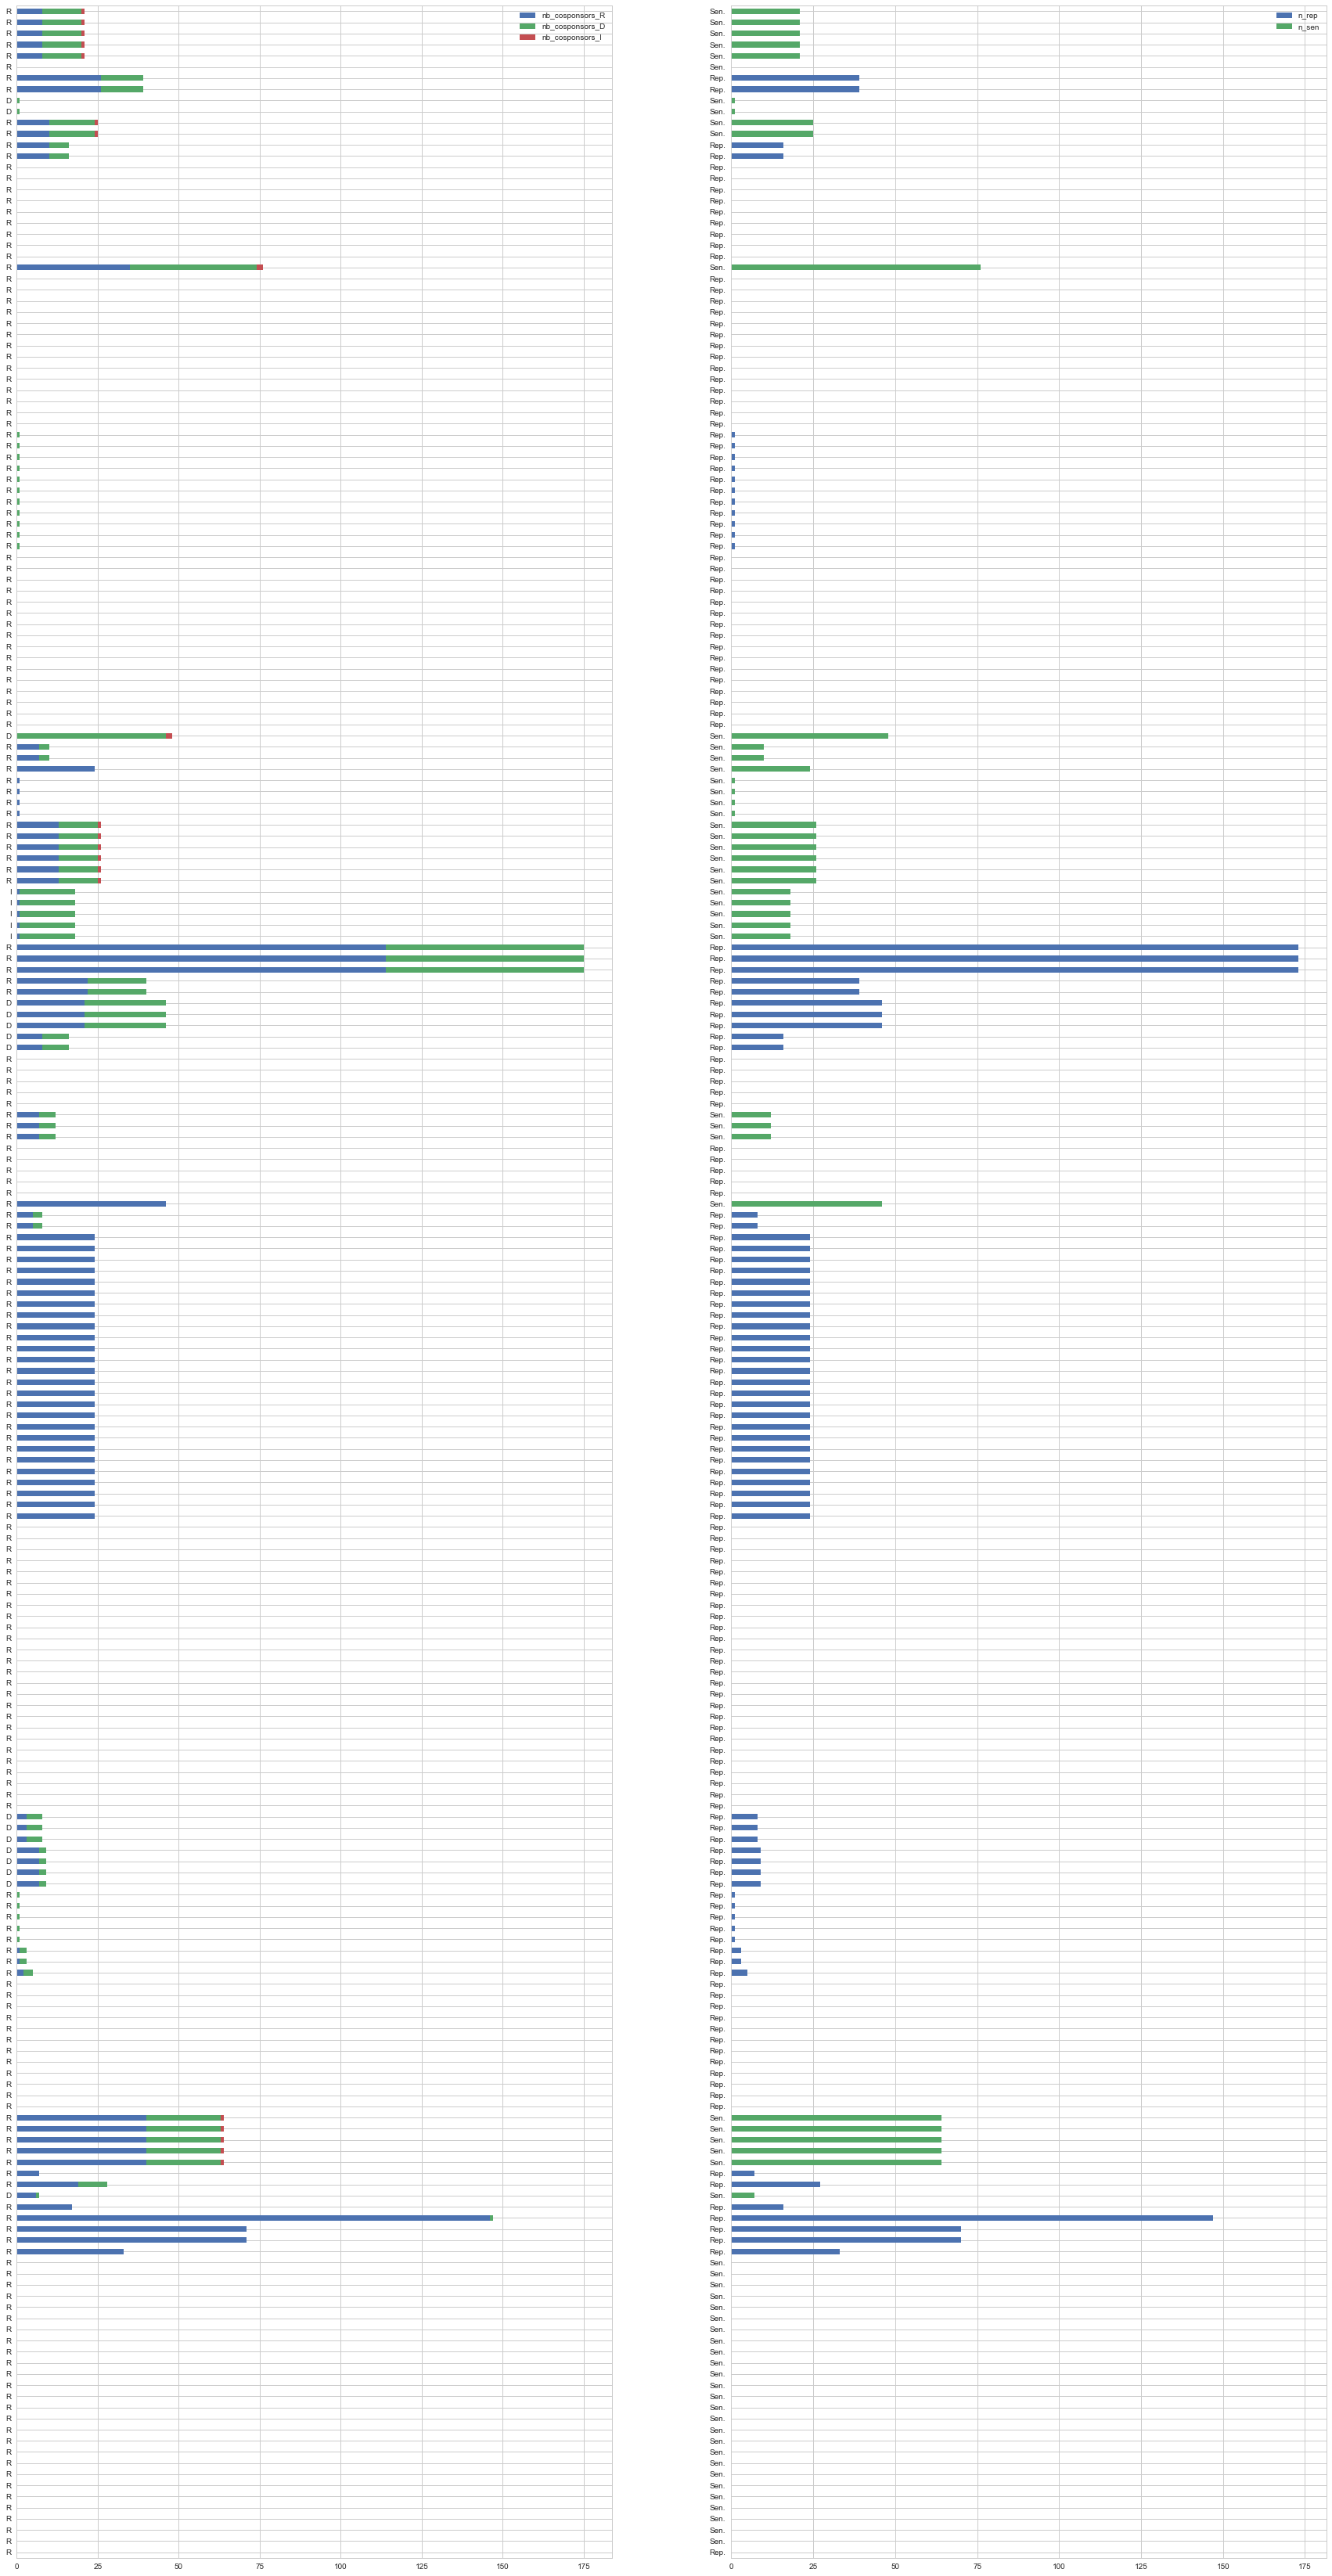

In [31]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(30,60))
aux_data1.loc[:,['nb_cosponsors_R', 'nb_cosponsors_D', 'nb_cosponsors_I']].plot(ax = ax1,kind='barh', stacked = True)
aux_data1.loc[:,['n_rep', 'n_sen']].plot(ax=ax2,kind='barh', stacked = True)
ax2.set_yticklabels(bills_115['sponsor_title']);
ax1.set_yticklabels(bills_115['sponsor_party']);

Note:
- The sponsor and cosponsors titles must be the same;
- 41% of the bills are sponsored by a senator, most of them republicans.
- Bills proposed by Democrats appear to pass with higher probability;
- Bills proposed by a member of the House of Representatives pass with higher probability than bills proposed by a member of the Senate (probably because it has already passed in the HoR).
- Bills with higher number of senators cosponsors appear to pass with higher probability.

In [32]:
# bills_115.to_csv('../data/bills_115.csv')